## Import Libraries and Set Mixed Precision Policy

In [2]:
import os
import tensorflow as tf
import random 
from transformers import BertTokenizer, TFBertModel
from datasets import Dataset, load_from_disk, concatenate_datasets
from tensorflow.keras.mixed_precision import experimental as mixed_precision
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.mixed_precision import LossScaleOptimizer

# Set mixed precision policy
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 6GB Laptop GPU, compute capability 8.6
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale


## Set TensorFlow GPU Configuration

In [2]:
# Configure TensorFlow to use GPU and set memory growth
#physical_devices = tf.config.list_physical_devices('GPU')
#if physical_devices:
#    try:
#        tf.config.experimental.set_memory_growth(physical_devices[0], True)
#    except RuntimeError as e:
#        print(e)


In [3]:
# Configure TensorFlow to use CPU (no specific configuration needed)
import tensorflow as tf

# List physical devices (just for verification)
physical_devices = tf.config.list_physical_devices('CPU')
print(f"Available CPU devices: {physical_devices}")


Available CPU devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Load IndoBERT Tokenizer and Model

In [4]:
# Load IndoBERT tokenizer and model (TensorFlow version)
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
bert_model = TFBertModel.from_pretrained("indobenchmark/indobert-base-p1")

# Enable gradient checkpointing for memory efficiency
bert_model.config.gradient_checkpointing = True


C:\Users\gabri\anaconda3\envs\myenv\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some layers from the model checkpoint at indobenchmark/indobert-base-p1 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-ba

## Define Generator for Reading Text Files

In [5]:
# Generator to read text files and clean text
def read_text_files_generator(folder_path):
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
                content = file.read().strip().lower()
                if content:
                    yield clean_text(content)

def clean_text(text):
    unwanted_chars = ['*', '#', '_', ')', '(', '!', '?', '.', ',', '-']
    for char in unwanted_chars:
        text = text.replace(char, '')
    return text


## Process and Tokenize Text in Batches Using Generator

In [6]:
# Define tokenize function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

# Function to tokenize and save batches
def tokenize_and_save_batch(texts, batch_index, tokenizer, save_dir):
    batch_dataset = Dataset.from_dict({"text": texts})
    tokenized_batch = batch_dataset.map(tokenize_function, batched=True, remove_columns=["text"])
    tokenized_batch.save_to_disk(f'{save_dir}/tokenized_dataset_batch_{batch_index}')

# Process texts in batches and save tokenized datasets
def process_in_batches(folder_path, batch_size, tokenizer, save_dir):
    batch_texts = []
    batch_index = 0
    for text in read_text_files_generator(folder_path):
        batch_texts.append(text)
        if len(batch_texts) >= batch_size:
            tokenize_and_save_batch(batch_texts, batch_index, tokenizer, save_dir)
            batch_texts = []
            batch_index += 1
    if batch_texts:
        tokenize_and_save_batch(batch_texts, batch_index, tokenizer, save_dir)

# Example usage:
process_in_batches('../Dataset/nlp_dataset', batch_size=100, tokenizer=tokenizer, save_dir='../saved_model/nlp_saved/nlp_03/new_tokenized')


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/92 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/92 [00:00<?, ? examples/s]

## Gradient Accumulation Setup

In [7]:
class AccumulatedOptimizer(tf.keras.optimizers.Optimizer):
    def __init__(self, optimizer, accumulation_steps=2):
        super(AccumulatedOptimizer, self).__init__(name="AccumulatedOptimizer")
        self.optimizer = optimizer
        self.accumulation_steps = accumulation_steps
        self.iterations = 0

    def apply_gradients(self, grads_and_vars, name=None, experimental_aggregate_gradients=True):
        if not hasattr(self, "grad_accumulation"):
            self.grad_accumulation = [tf.zeros_like(var) for _, var in grads_and_vars]

        # Accumulate gradients
        self.grad_accumulation = [
            acc + grad / tf.cast(self.accumulation_steps, tf.float32)
            for acc, (grad, _) in zip(self.grad_accumulation, grads_and_vars)
        ]

        self.iterations += 1

        if self.iterations % self.accumulation_steps == 0:
            # Apply accumulated gradients
            self.optimizer.apply_gradients(
                zip(self.grad_accumulation, [var for _, var in grads_and_vars])
            )
            # Reset accumulation
            self.grad_accumulation = [
                tf.zeros_like(var) for _, var in grads_and_vars
            ]


## Caching and Mapping Dataset

In [8]:
# Load dataset with caching for efficient memory usage
def load_and_prepare_dataset_with_caching(batch_index, save_dir):
    batch_dataset = load_from_disk(f'{save_dir}/tokenized_dataset_batch_{batch_index}')
    
    # Caching to improve efficiency
    dataset = batch_dataset.to_tf_dataset(
        columns=["input_ids", "attention_mask"],
        label_cols=["input_ids"],
        shuffle=True,
        batch_size=1,  # Use batch size of 1 to minimize memory use
        collate_fn=None,
    ).cache().map(lambda x, y: (x, y), num_parallel_calls=tf.data.experimental.AUTOTUNE)

    return dataset.prefetch(tf.data.experimental.AUTOTUNE)


## Define and Compile BertAutoencoder Model

In [9]:
# Define the BertAutoencoder model
class BertAutoencoder(tf.keras.Model):
    def __init__(self, bert_model):
        super(BertAutoencoder, self).__init__()
        self.bert = bert_model
        self.dense = tf.keras.layers.Dense(bert_model.config.vocab_size, activation='softmax', dtype='float32')

    def call(self, inputs):
        outputs = self.bert(**inputs)
        sequence_output = outputs.last_hidden_state
        reconstructed = self.dense(sequence_output)
        return reconstructed

# Instantiate the model
autoencoder_model = BertAutoencoder(bert_model)

# Define the optimizer
optimizer = Adam(learning_rate=2e-5)

# Compile the model
autoencoder_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)


  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)



## Implement Gradient Accumulation in Training Loop

In [11]:
# Define the training step wrapped in tf.function
@tf.function
def train_step(model, optimizer, x_batch_train, y_batch_train):
    with tf.GradientTape() as tape:
        logits = model(x_batch_train, training=True)
        loss_value = model.compiled_loss(y_batch_train, logits)
    
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    
    return loss_value


# Tambahkan variabel untuk menyimpan loss
loss_history = []

def train_model_with_optimization_and_save(model, num_batches, save_dir, save_model_path, accumulation_steps=16):
    for i in range(num_batches):
        print(f"Training on batch {i+1}/{num_batches}")
        train_dataset = load_and_prepare_dataset_with_caching(i, save_dir)
        
        step = 0
        for x_batch_train, y_batch_train in train_dataset:
            step += 1
            # Perform training step with tf.function
            loss_value = train_step(model, optimizer, x_batch_train, y_batch_train)
            
            if step % accumulation_steps == 0:
                # Log every accumulation step
                print(f"Step {step}: Loss: {loss_value.numpy()}")
    
    # Simpan model setelah pelatihan selesai
    model.save(save_model_path)
    print(f"Model saved to {save_model_path}")

# Contoh penggunaan
train_model_with_optimization_and_save(autoencoder_model, 13, '../saved_model/nlp_saved/nlp_03/new_tokenized', '../saved_model/nlp_saved/nlp_03/saved_model_directory', accumulation_steps=8)

Training on batch 1/13
Step 8: Loss: 2.8689424991607666
Step 16: Loss: 1.1023693084716797
Step 24: Loss: 2.145442008972168
Step 32: Loss: 0.835431694984436
Step 40: Loss: 1.0290364027023315
Step 48: Loss: 1.8634346723556519
Step 56: Loss: 2.9927496910095215
Step 64: Loss: 2.7182886600494385
Step 72: Loss: 1.1427456140518188
Step 80: Loss: 2.0275275707244873
Step 88: Loss: 1.785470962524414
Step 96: Loss: 0.552955150604248
Training on batch 2/13
Step 8: Loss: 1.2938839197158813
Step 16: Loss: 1.6366604566574097
Step 24: Loss: 1.5060174465179443
Step 32: Loss: 0.6831838488578796
Step 40: Loss: 1.0494234561920166
Step 48: Loss: 1.0559026002883911
Step 56: Loss: 1.1589046716690063
Step 64: Loss: 0.5934618711471558
Step 72: Loss: 1.1583428382873535
Step 80: Loss: 1.5180381536483765
Step 88: Loss: 1.230949878692627
Step 96: Loss: 0.6484699249267578
Training on batch 3/13
Step 8: Loss: 2.2283945083618164
Step 16: Loss: 1.215683937072754
Step 24: Loss: 2.823082685470581
Step 32: Loss: 0.966679

INFO:tensorflow:Assets written to: ../saved_model/nlp_saved/nlp_03/saved_model_directory\assets


INFO:tensorflow:Assets written to: ../saved_model/nlp_saved/nlp_03/saved_model_directory\assets


Model saved to ../saved_model/nlp_saved/nlp_03/saved_model_directory


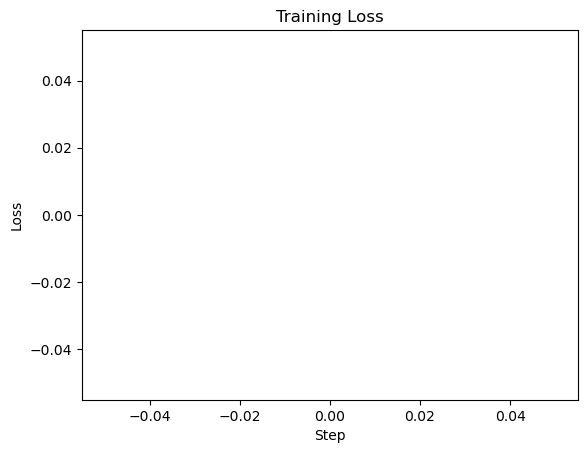

In [12]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

In [3]:
# Load model yang telah disimpan
loaded_model = tf.keras.models.load_model('../saved_model/nlp_saved/nlp_03/saved_model_directory')

# Pastikan model sudah ter-load dengan benar
loaded_model.summary()

C:\Users\gabri\anaconda3\envs\myenv\lib\site-packages\transformers\configuration_utils.py:365: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


ValueError: The two structures don't have the same nested structure.

First structure: type=tuple str=(({'attention_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name=None), 'input_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_ids/input_ids')}, None, None, None, None, None, None, None, None, None, None, None, None, False), {})

Second structure: type=tuple str=((TensorSpec(shape=(None, 512), dtype=tf.int64, name='input_ids'), TensorSpec(shape=(None, 512), dtype=tf.int64, name='attention_mask'), None, None, None, None, None, None, None, None, None, None, None, False), {})

More specifically: Substructure "type=dict str={'attention_mask': TensorSpec(shape=(None, None), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name=None), 'input_ids': TensorSpec(shape=(None, None), dtype=tf.int32, name='input_ids/input_ids')}" is a sequence, while substructure "type=TensorSpec str=TensorSpec(shape=(None, 512), dtype=tf.int64, name='input_ids')" is not
Entire first structure:
(({'attention_mask': ., 'token_type_ids': ., 'input_ids': .}, ., ., ., ., ., ., ., ., ., ., ., ., .), {})
Entire second structure:
((., ., ., ., ., ., ., ., ., ., ., ., ., .), {})